In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# ======================
# Configuration
# ======================
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42
LATENT_DIM = 256  # Must match autoencoder's latent dimension

# ======================
# Data Pipeline
# ======================

# Autoencoder training data (normal images only)
ae_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2
)

# Autoencoder generators
train_gen = ae_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal'],
    class_mode='input',
    batch_size=BATCH_SIZE,
    subset='training',
    seed=SEED
)

val_gen = ae_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal'],
    class_mode='input',
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=SEED
)

# Labeled data generators (both classes)
labeled_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data with labels
train_labeled = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal', 'dr'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=False  # Critical for label consistency
)

# Validation data with labels
val_labeled = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    classes=['normal', 'dr'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

# ======================
# Autoencoder Training
# ======================

def build_autoencoder(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Latent space
    shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    x = tf.keras.layers.Flatten()(x)
    latent = tf.keras.layers.Dense(LATENT_DIM, activation='relu', name='latent_vector')(x)

    # Decoder
    x = tf.keras.layers.Dense(np.prod(shape_before_flatten))(latent)
    x = tf.keras.layers.Reshape(shape_before_flatten)(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same', strides=2)(x)
    outputs = tf.keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    return tf.keras.Model(inputs, outputs)

# Train autoencoder
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')

autoencoder.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)



Found 4124 images belonging to 1 classes.
Found 1030 images belonging to 1 classes.
Found 8339 images belonging to 2 classes.
Found 2083 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 0.0749 - val_loss: 0.0949
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0192 - val_loss: 0.0597
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - loss: 0.0094 - val_loss: 0.0217
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - loss: 0.0058 - val_loss: 0.0067
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 0.0049 - val_loss: 0.0040
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - loss: 0.0036 - val_loss: 0.0031
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - loss: 0.0028 - val_loss: 0.0027
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
autoencoder.save('autoencoder_model.keras')



Logistic Regression Performance:
              precision    recall  f1-score   support

      Normal       0.90      0.93      0.91      1030
          DR       0.93      0.90      0.91      1053

    accuracy                           0.91      2083
   macro avg       0.91      0.91      0.91      2083
weighted avg       0.91      0.91      0.91      2083


Neural Network Classifier Training:
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7507 - auc: 0.7921 - loss: 1.2410 - val_accuracy: 0.9011 - val_auc: 0.9706 - val_loss: 0.2236
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8928 - auc: 0.9586 - loss: 0.2594 - val_accuracy: 0.9145 - val_auc: 0.9748 - val_loss: 0.2060
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9228 - auc: 0.9740 - loss: 0.2059 - val_accuracy: 0.9165 - val_auc: 0.9821 - val_loss: 0.1732
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9295 - auc: 0.9831 - loss: 0.1635 - val_accuracy: 0.9213 - val_auc: 0.9808 - val_loss: 0.1753
Epoch 5/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9343 - auc: 0.9850 - loss: 0.1546 - val_accuracy: 0.9270 - val_auc: 0.9856 - val_loss: 0.1572
Epoch 6/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9497 - auc: 0.9900 - loss: 0.1275 - val_accuracy: 0.9136 - val_auc: 0.9826 - val_loss: 0.1972
Epoch 7/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

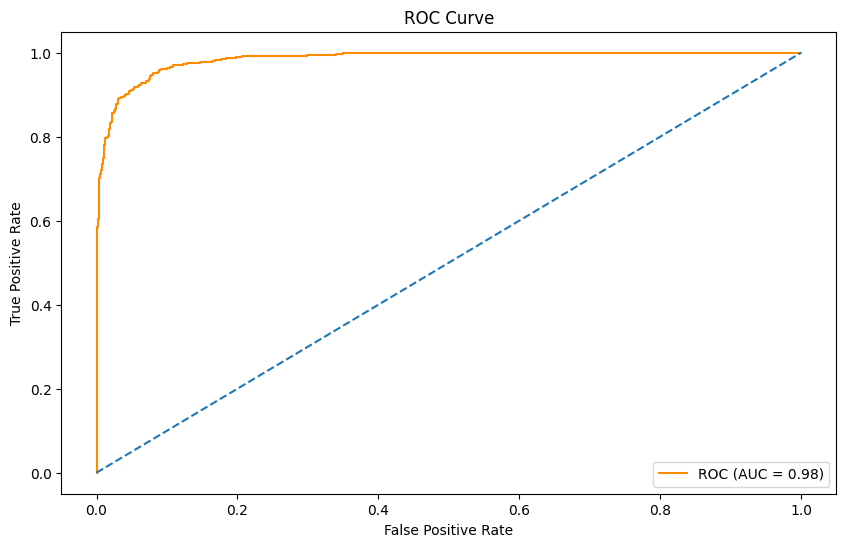

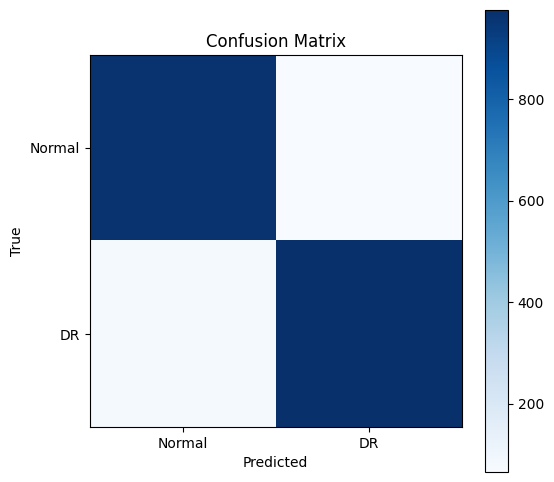


Final Evaluation:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      1030
         1.0       0.94      0.93      0.93      1053

    accuracy                           0.93      2083
   macro avg       0.93      0.93      0.93      2083
weighted avg       0.93      0.93      0.93      2083

AUC Score: 0.985


In [9]:
# ======================
# Feature Extraction
# ======================

# Create encoder model
encoder = tf.keras.Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer('latent_vector').output
)

# Extract features from labeled data
def extract_features(generator):
    features, labels = [], []
    generator.reset()
    for _ in range(len(generator)):
        img, label = next(generator)
        features.append(encoder.predict(img, verbose=0))
        labels.append(label)
    return np.vstack(features), np.concatenate(labels)

X_train, y_train = extract_features(train_labeled)
X_val, y_val = extract_features(val_labeled)

# ======================
# Classification Models
# ======================

# Option 1: Logistic Regression
print("\nLogistic Regression Performance:")
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['Normal', 'DR']))

# Option 2: Neural Network Classifier
classifier = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(LATENT_DIM,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

classifier.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

print("\nNeural Network Classifier Training:")
classifier.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

# ======================
# Advanced: Multi-class Classification
# ======================
# (Requires dataset with severity stages 0-4)

# Uncomment if using severity classes
"""
# Reload data with categorical labels
train_labeled_multi = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=False
)

val_labeled_multi = labeled_datagen.flow_from_directory(
    'dr_dataset/training/',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False
)

# Extract features and labels
X_train_multi, y_train_multi = extract_features(train_labeled_multi)
X_val_multi, y_val_multi = extract_features(val_labeled_multi)

# Build multi-class classifier
classifier_multi = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(LATENT_DIM,)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

classifier_multi.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

classifier_multi.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_val_multi, y_val_multi),
    epochs=30,
    batch_size=32
)
"""

# ======================
# Visualization & Analysis
# ======================

# ROC Curve for binary classification
y_proba = classifier.predict(X_val).flatten()
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, (y_proba > 0.5).astype(int))
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0,1], ['Normal', 'DR'])
plt.yticks([0,1], ['Normal', 'DR'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nFinal Evaluation:")
print("Classification Report:")
print(classification_report(y_val, (y_proba > 0.5).astype(int)))
print(f"AUC Score: {roc_auc:.3f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


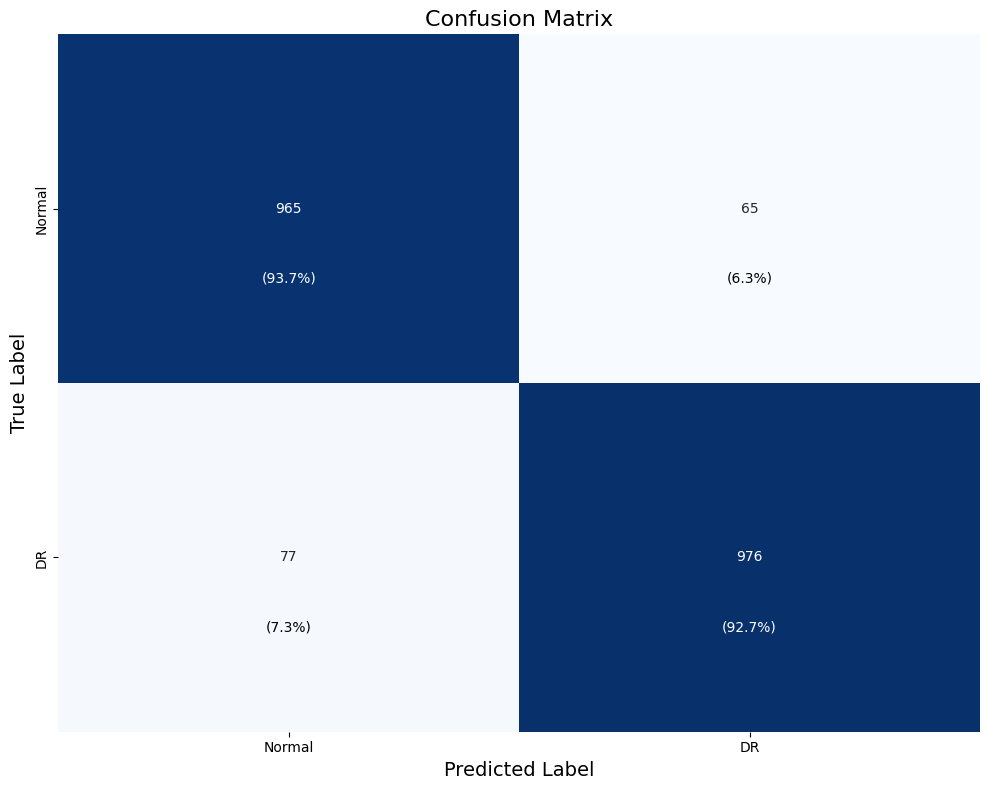

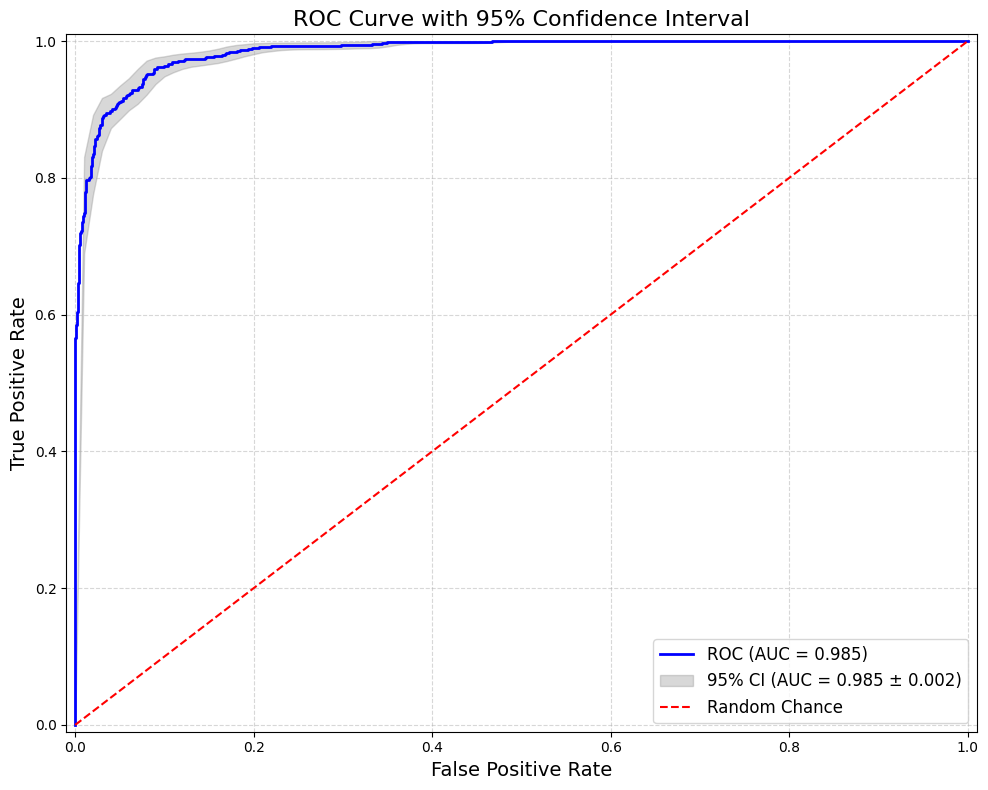

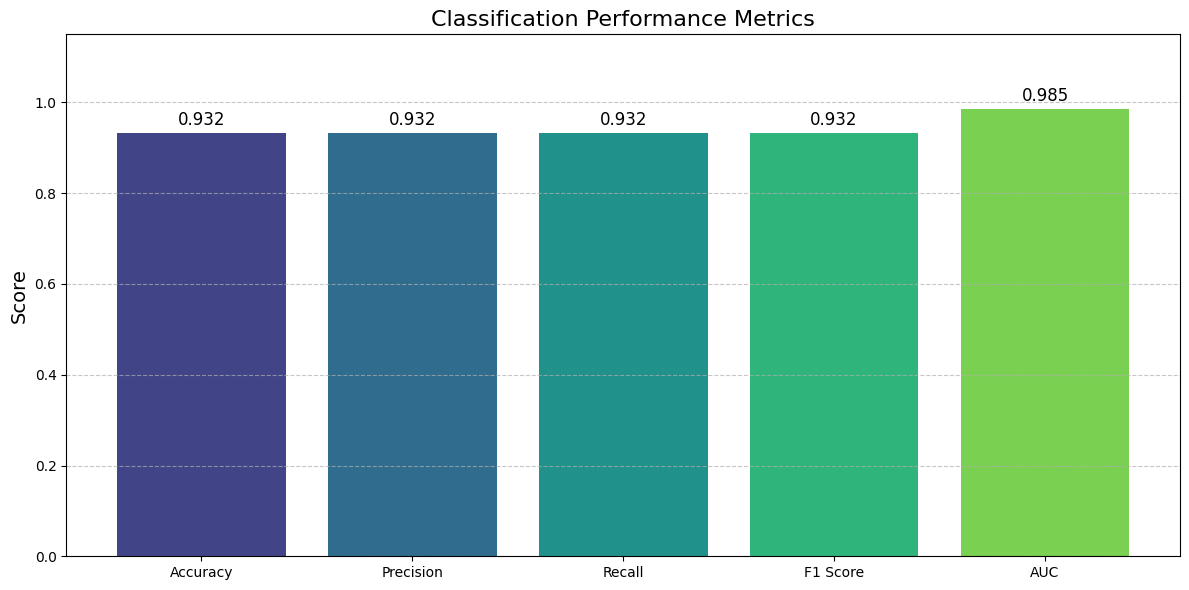


===== CLASSIFICATION METRICS =====
Accuracy: 0.932
Precision (weighted): 0.932
Recall (weighted): 0.932
F1 Score (weighted): 0.932
AUC: 0.985

===== PER-CLASS METRICS =====


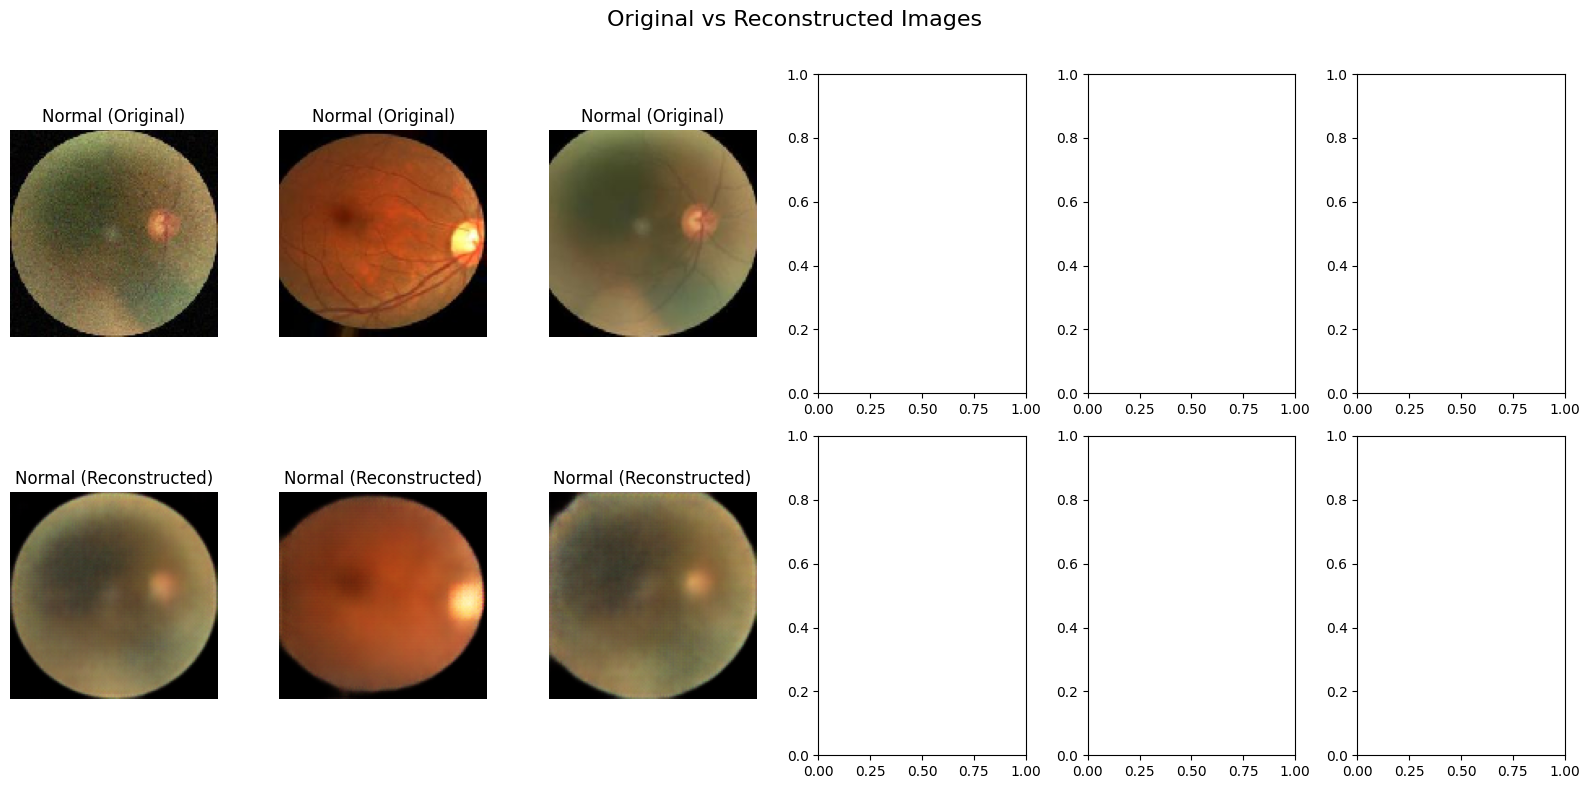

Computing t-SNE embedding...


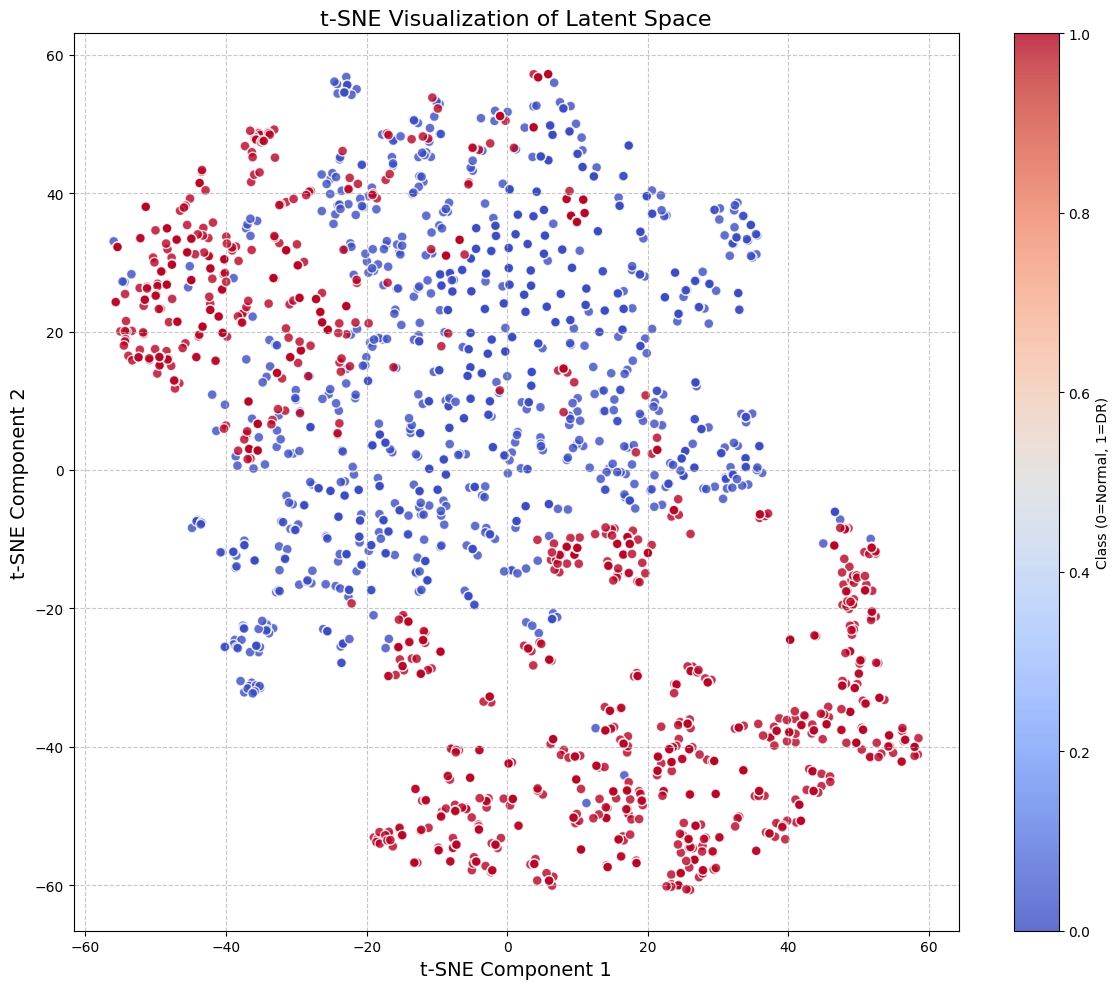

In [12]:
# ======================
# Enhanced Visualization & Analysis
# ======================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 1. Create a better confusion matrix visualization
def plot_confusion_matrix(y_true, y_pred, class_names=['Normal', 'DR']):
    """
    Plot a more attractive confusion matrix with percentages and counts
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    # Calculate percentages
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create visualization with seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    # Add percentage labels
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.7, f'({cm_norm[i, j]:.1%})',
                     ha='center', va='center', color='black' if cm_norm[i, j] < 0.7 else 'white')

    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.tight_layout()
    plt.show()

# 2. Plot ROC curve with confidence interval
def plot_roc_curve_with_ci(y_true, y_score, n_bootstraps=1000, rng_seed=42):
    """
    Plot ROC curve with confidence interval using bootstrapping
    """
    plt.figure(figsize=(10, 8))

    # Calculate the base ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label=f'ROC (AUC = {roc_auc:.3f})', linewidth=2)

    # Set up the bootstrap
    np.random.seed(rng_seed)

    # Create arrays to store bootstrap results
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    # Perform bootstrapping
    for i in range(n_bootstraps):
        # Sample with replacement
        indices = np.random.randint(0, len(y_score), len(y_score))
        if len(np.unique(np.array(y_true)[indices])) < 2:
            # Skip this bootstrap if it doesn't have both classes
            continue

        # Calculate ROC for the bootstrap sample
        fpr, tpr, _ = roc_curve(np.array(y_true)[indices], np.array(y_score)[indices])

        # Interpolate to common base
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0

        # Store interpolated values
        tprs.append(tpr_interp)
        aucs.append(auc(fpr, tpr))

    # Calculate confidence intervals
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + 1.96 * std_tprs, 1)
    tprs_lower = mean_tprs - 1.96 * std_tprs

    # Plot the confidence interval
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3,
                     label=f'95% CI (AUC = {np.mean(aucs):.3f} ± {np.std(aucs):.3f})')

    plt.plot([0, 1], [0, 1], 'r--', label='Random Chance', linewidth=1.5)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with 95% Confidence Interval', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return roc_auc, np.mean(aucs), np.std(aucs)

# 3. Comprehensive metrics visualization
def plot_classification_metrics(y_true, y_pred, y_score):
    """
    Create a visual dashboard of classification metrics
    """
    # Calculate metrics
    report = classification_report(y_true, y_pred, target_names=['Normal', 'DR'], output_dict=True, zero_division=0) # Added zero_division=0 to handle cases where one class has no predicted samples
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # Calculate AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot metrics
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    values = [accuracy, precision, recall, f1, roc_auc]

    # Create colormap
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(metrics)))

    # Create bar chart
    bars = plt.bar(metrics, values, color=colors)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=12)

    plt.ylim([0, 1.15])
    plt.title('Classification Performance Metrics', fontsize=16)
    plt.ylabel('Score', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\n===== CLASSIFICATION METRICS =====")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision (weighted): {precision:.3f}")
    print(f"Recall (weighted): {recall:.3f}")
    print(f"F1 Score (weighted): {f1:.3f}")
    print(f"AUC: {roc_auc:.3f}")

    # Print per-class metrics (handling potential KeyError)
    print("\n===== PER-CLASS METRICS =====")
    for label, metrics in report.items():
        if label.isdigit():  # Check if the key is a class label (0 or 1)
            class_name = 'Normal' if label == '0' else 'DR'  # Map label to class name
            try:
                print(f"{class_name} - Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1-score']:.3f}")
            except KeyError:
                print(f"{class_name} - Metrics not available (likely due to no predicted samples for this class)")

# 4. Function to visualize reconstructed images
def plot_reconstructions(autoencoder, original_data, labels, num_examples=5):
    """
    Plot original and reconstructed images for both classes
    """
    # Get reconstructions
    reconstructions = autoencoder.predict(original_data, verbose=0)

    # Find indices for normal and DR cases
    normal_indices = np.where(labels == 0)[0]
    dr_indices = np.where(labels == 1)[0]

    # Ensure we have enough samples
    num_normal = min(num_examples, len(normal_indices))
    num_dr = min(num_examples, len(dr_indices))

    # Randomly select indices
    np.random.shuffle(normal_indices)
    np.random.shuffle(dr_indices)

    # Create figure
    fig, axes = plt.subplots(2, 2 * num_examples, figsize=(16, 8))

    # Plot normal cases
    for i in range(num_normal):
        idx = normal_indices[i]

        # Original image
        # The original data is likely in RGB format, so display it as such
        axes[0, i].imshow(original_data[idx])
        axes[0, i].set_title(f"Normal (Original)")
        axes[0, i].axis('off')

        # Reconstructed image
        # Reconstructions should also be in RGB format
        axes[1, i].imshow(reconstructions[idx])
        axes[1, i].set_title(f"Normal (Reconstructed)")
        axes[1, i].axis('off')

    # Plot DR cases
    for i in range(num_dr):
        idx = dr_indices[i]

        # Original image
        axes[0, i+num_normal].imshow(original_data[idx])
        axes[0, i+num_normal].set_title(f"DR (Original)")
        axes[0, i+num_normal].axis('off')

        # Reconstructed image
        axes[1, i+num_normal].imshow(reconstructions[idx])
        axes[1, i+num_normal].set_title(f"DR (Reconstructed)")
        axes[1, i+num_normal].axis('off')

    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
# 5. Latent space visualization with t-SNE
def visualize_latent_space(X, y, perplexity=30):
    """
    Visualize the latent space using t-SNE
    """
    from sklearn.manifold import TSNE

    # Apply t-SNE
    print("Computing t-SNE embedding...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Create scatter plot
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,
                          cmap='coolwarm', alpha=0.8, s=50, edgecolors='w')

    plt.colorbar(scatter, label='Class (0=Normal, 1=DR)')
    plt.title('t-SNE Visualization of Latent Space', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ======================
# Run all visualizations
# ======================

# Get predictions
y_proba = classifier.predict(X_val).flatten()
y_pred = (y_proba > 0.5).astype(int)

# 1. Plot enhanced confusion matrix
plot_confusion_matrix(y_val, y_pred)

# 2. Plot ROC curve with confidence interval
plot_roc_curve_with_ci(y_val, y_proba, n_bootstraps=500)

# 3. Create metrics dashboard
plot_classification_metrics(y_val, y_pred, y_proba)

# 4. Visualize reconstructions
# Get a batch of validation images
validation_batch = next(val_labeled)
plot_reconstructions(autoencoder, validation_batch[0], validation_batch[1], num_examples=3)

# 5. Visualize latent space (t-SNE)
visualize_latent_space(X_val, y_val)


===== VALIDATING DATA =====

=== Checking validation set ===
X shape: (2083, 256)
y shape: (2083,)
Class distribution: {np.float32(0.0): np.int64(1030), np.float32(1.0): np.int64(1053)}
NaN values in X: False
Infinite values in X: False
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Class distribution: {np.float32(0.0): np.int64(1030), np.float32(1.0): np.int64(1053)}


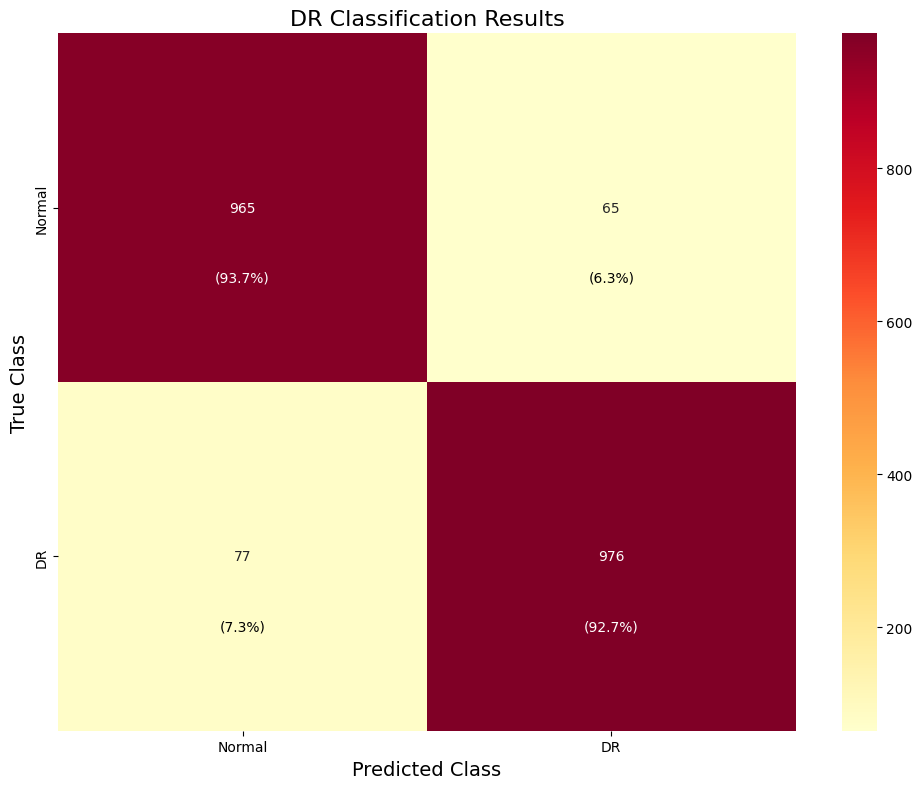


===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

      Normal       0.93      0.94      0.93      1030
          DR       0.94      0.93      0.93      1053

    accuracy                           0.93      2083
   macro avg       0.93      0.93      0.93      2083
weighted avg       0.93      0.93      0.93      2083



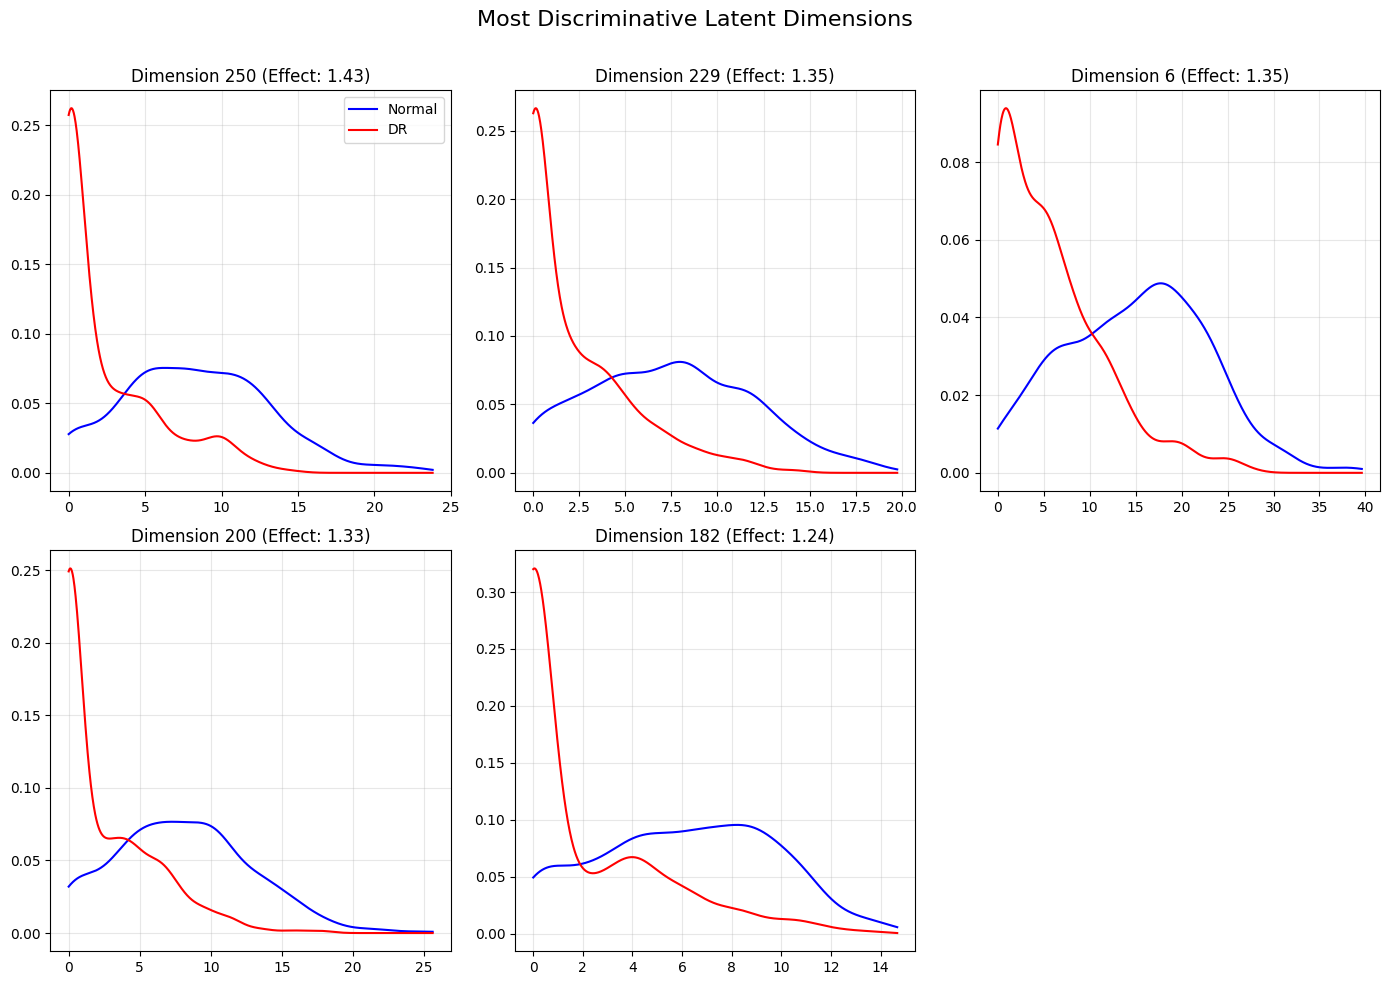


===== MOST DISCRIMINATIVE LATENT DIMENSIONS =====
Dimension 250: Effect Size = 1.431
  Normal: mean = 8.341, std = 4.783
  DR: mean = 2.443, std = 3.334
Dimension 229: Effect Size = 1.351
  Normal: mean = 7.431, std = 4.460
  DR: mean = 2.317, std = 2.960
Dimension 6: Effect Size = 1.346
  Normal: mean = 15.001, std = 7.719
  DR: mean = 5.864, std = 5.705
Dimension 200: Effect Size = 1.328
  Normal: mean = 8.033, std = 4.766
  DR: mean = 2.553, std = 3.369
Dimension 182: Effect Size = 1.244
  Normal: mean = 6.106, std = 3.534
  DR: mean = 2.033, std = 2.988


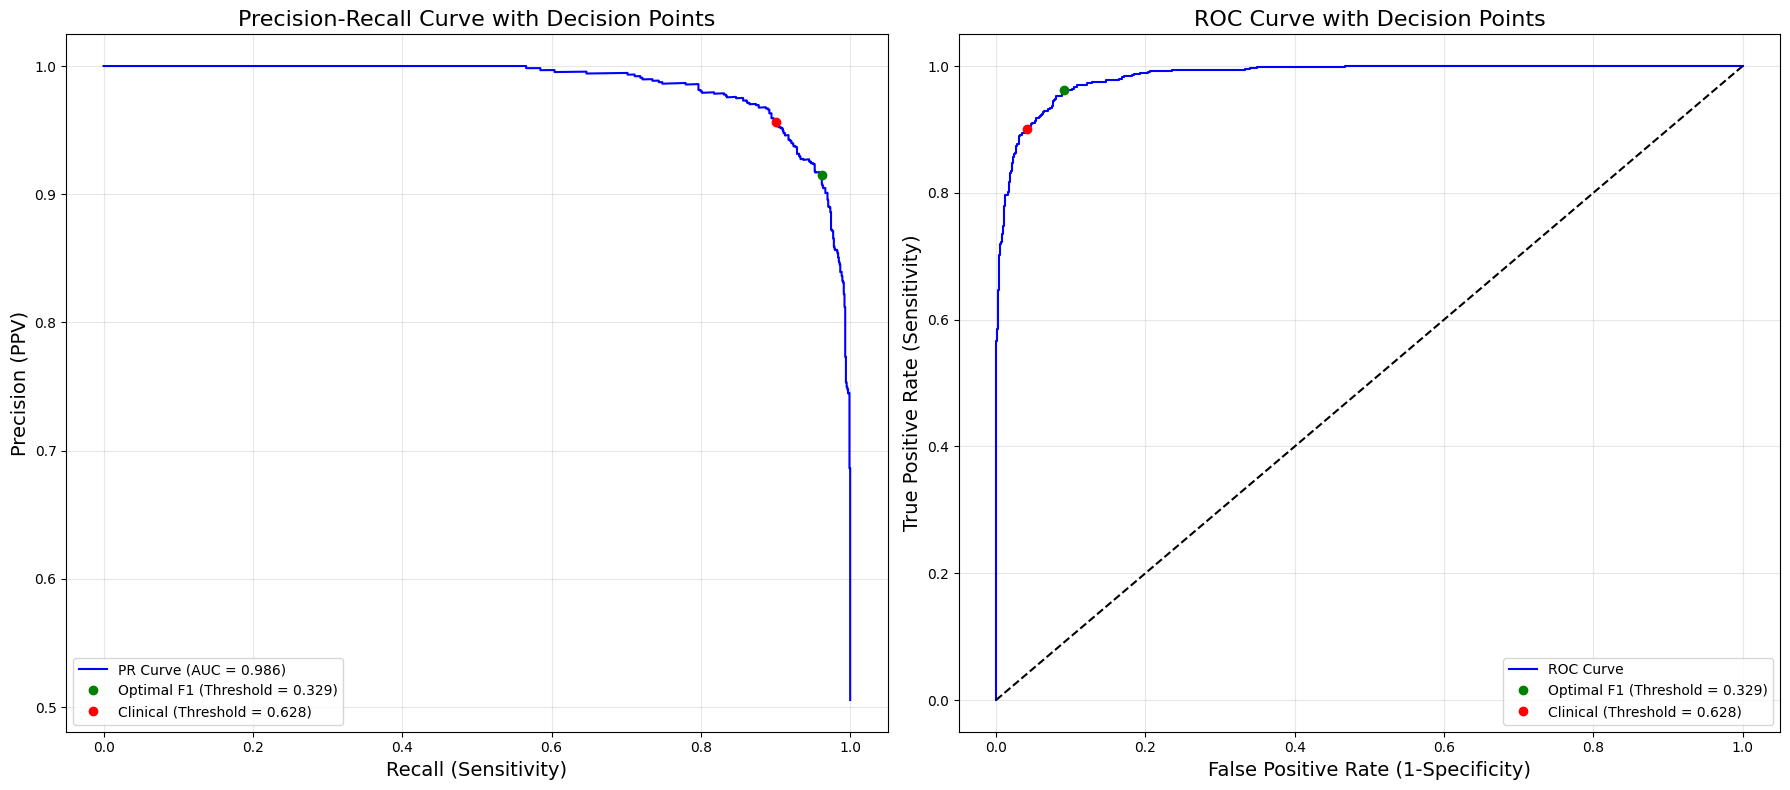


===== CLINICAL THRESHOLD ANALYSIS =====
Default threshold (0.5): Accuracy = 0.932, Sensitivity = 0.927, Specificity = 0.936
Optimal F1 threshold (0.329): Accuracy = 0.936, Sensitivity = 0.962, Specificity = 0.909
Clinical threshold (0.628): Accuracy = 0.929, Sensitivity = 0.900, Specificity = 0.958


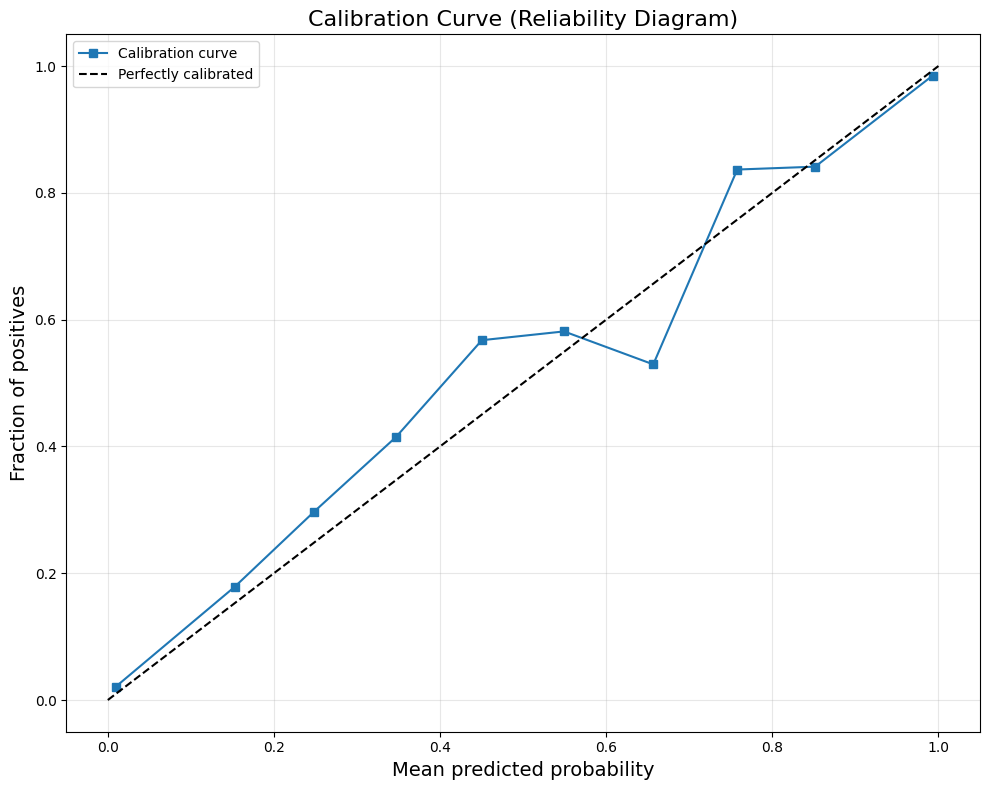


Calibration Brier score: 0.0482 (lower is better, 0 is perfect)
Model is well-calibrated.


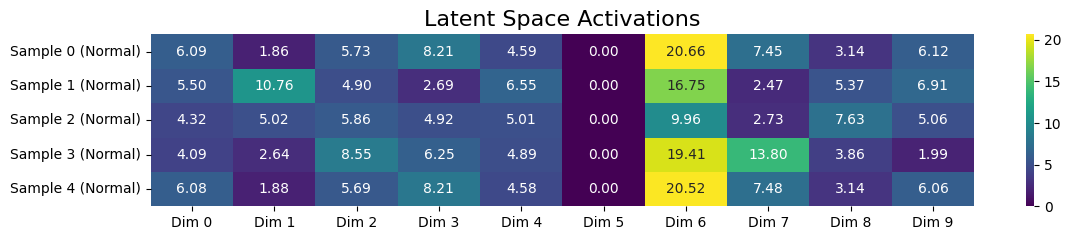

Class distribution: {np.float32(0.0): np.int64(32)}
Missing or insufficient samples for class 1

===== DR FEATURE ENCODER ARCHITECTURE =====


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 256)            │     4,194,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,584,896 (17.49 MB)

 Trainable params: 4,583,936 (17.49 MB)

 Non-trainable params: 960 (3.75 KB)


DR Feature Encoder layers:
Could not visualize model architecture: 'InputLayer' object has no attribute 'output_shape'


In [16]:
# ======================
# Fixed DR-Specific Visualizations
# ======================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from sklearn.calibration import calibration_curve

# Helper function to check data validity
def check_data_validity(X, y, name="dataset"):
    """Check if data has valid structure and class distribution"""
    print(f"\n=== Checking {name} ===")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    # Check class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")

    # Check for NaN values
    print(f"NaN values in X: {np.isnan(X).any()}")
    if np.isnan(X).any():
        print(f"Number of NaN values: {np.isnan(X).sum()}")

    # Check for infinite values
    print(f"Infinite values in X: {np.isinf(X).any()}")
    if np.isinf(X).any():
        print(f"Number of infinite values: {np.isinf(X).sum()}")

    return len(unique) > 1  # Return True if we have more than one class

# 1. Fixed DR Severity Confusion Analysis
def plot_dr_severity_confusion(y_true, y_pred_proba, class_names=['Normal', 'DR']):
    """Plot confusion matrix specifically for DR severity levels with proper validation"""

    # Validate inputs
    if len(y_true) == 0:
        print("Error: Empty ground truth array")
        return

    # Check for class imbalance
    unique, counts = np.unique(y_true, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"Class distribution: {class_dist}")

    # Make sure we have both classes
    if len(unique) < 2:
        print(f"Warning: Only found class {unique[0]} in the validation set")
        return

    # Convert probabilities to class predictions
    if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        # For binary classification
        y_pred = (y_pred_proba > 0.5).astype(int)
        class_names = class_names[:2]  # Use only first two classes

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix by row (true labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
                xticklabels=class_names, yticklabels=class_names)

    # Add percentage labels
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # Check for division by zero
            if not np.isnan(cm_norm[i, j]):
                plt.text(j + 0.5, i + 0.7, f'({cm_norm[i, j]:.1%})',
                        ha='center', va='center',
                        color='black' if cm_norm[i, j] < 0.7 else 'white')

    plt.title('DR Classification Results', fontsize=16)
    plt.ylabel('True Class', fontsize=14)
    plt.xlabel('Predicted Class', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print("\n===== CLASSIFICATION REPORT =====")
    print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Fixed Latent Space Analysis
def analyze_latent_dimensions(X, y, top_n=5):
    """Analyze which latent dimensions are most discriminative with proper validation"""

    # Validate inputs
    if len(y) == 0:
        print("Error: Empty label array")
        return None, None

    # Check class distribution
    unique, counts = np.unique(y, return_counts=True)
    if len(unique) < 2:
        print(f"Warning: Only found class {unique[0]} in the dataset")
        return None, None

    # Separate data by class
    X_normal = X[y == 0]
    X_dr = X[y == 1]

    if len(X_normal) == 0 or len(X_dr) == 0:
        print("Error: One of the classes has no samples")
        return None, None

    # Calculate statistics
    mean_normal = np.mean(X_normal, axis=0)
    mean_dr = np.mean(X_dr, axis=0)
    std_normal = np.std(X_normal, axis=0)
    std_dr = np.std(X_dr, axis=0)

    # Calculate effect size (absolute standardized mean difference)
    pooled_std = np.sqrt((std_normal**2 + std_dr**2) / 2)
    # Avoid division by zero
    pooled_std[pooled_std == 0] = 1e-10
    effect_size = np.abs(mean_normal - mean_dr) / pooled_std

    # Find top discriminative dimensions
    latent_dim = X.shape[1]
    top_dims = np.argsort(effect_size)[::-1]

    # Create plot for top dimensions
    num_dims = min(top_n, latent_dim, 10)  # Show at most 10 dimensions
    plt.figure(figsize=(14, 10))

    for i, dim in enumerate(top_dims[:num_dims]):
        plt.subplot(2, int(np.ceil(num_dims/2)), i+1)

        try:
            # Create density plots if we have enough data
            if len(X_normal) >= 5 and len(X_dr) >= 5:
                kde_normal = gaussian_kde(X_normal[:, dim])
                kde_dr = gaussian_kde(X_dr[:, dim])

                # Create evaluation points
                x_min = min(np.min(X_normal[:, dim]), np.min(X_dr[:, dim]))
                x_max = max(np.max(X_normal[:, dim]), np.max(X_dr[:, dim]))
                x = np.linspace(x_min, x_max, 1000)

                # Plot densities
                plt.plot(x, kde_normal(x), 'b-', label='Normal')
                plt.plot(x, kde_dr(x), 'r-', label='DR')
            else:
                # Fallback to histograms for small datasets
                plt.hist(X_normal[:, dim], alpha=0.5, color='blue', bins=10, density=True, label='Normal')
                plt.hist(X_dr[:, dim], alpha=0.5, color='red', bins=10, density=True, label='DR')
        except Exception as e:
            print(f"Error plotting dimension {dim}: {str(e)}")
            # Fallback option
            plt.text(0.5, 0.5, f"Error plotting\ndimension {dim}",
                     ha='center', va='center', transform=plt.gca().transAxes)

        plt.title(f"Dimension {dim} (Effect: {effect_size[dim]:.2f})")
        if i == 0:
            plt.legend()
        plt.grid(alpha=0.3)

    plt.suptitle("Most Discriminative Latent Dimensions", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print information about top dimensions
    print("\n===== MOST DISCRIMINATIVE LATENT DIMENSIONS =====")
    for i, dim in enumerate(top_dims[:min(5, latent_dim)]):
        print(f"Dimension {dim}: Effect Size = {effect_size[dim]:.3f}")
        print(f"  Normal: mean = {mean_normal[dim]:.3f}, std = {std_normal[dim]:.3f}")
        print(f"  DR: mean = {mean_dr[dim]:.3f}, std = {std_dr[dim]:.3f}")

    return top_dims, effect_size

# 3. Fixed Clinical Decision Threshold Analysis
def clinical_threshold_analysis(y_true, y_score):
    """Analyze different probability thresholds from a clinical perspective with validation"""

    # Validate inputs
    if len(y_true) == 0:
        print("Error: Empty ground truth array")
        return

    # Check class distribution
    unique, counts = np.unique(y_true, return_counts=True)
    if len(unique) < 2:
        print(f"Warning: Only found class {unique[0]} in the dataset")
        return

    # Calculate precision-recall curve
    try:
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        pr_auc = average_precision_score(y_true, y_score)

        # Calculate F1 score for each threshold
        # Avoid division by zero
        epsilon = 1e-10
        f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
    except Exception as e:
        print(f"Error calculating precision-recall curve: {str(e)}")
        return

    # Calculate ROC
    try:
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
    except Exception as e:
        print(f"Error calculating ROC curve: {str(e)}")
        return

    # Find optimal thresholds
    try:
        optimal_f1_idx = np.argmax(f1_scores)
        optimal_f1_threshold = thresholds[optimal_f1_idx] if optimal_f1_idx < len(thresholds) else 1.0

        # For clinical settings, we might prefer a high sensitivity (recall)
        clinical_idx = np.where(recall >= 0.90)[0][-1] if any(recall >= 0.90) else len(recall)-1
        clinical_threshold = thresholds[clinical_idx] if clinical_idx < len(thresholds) else 0.0
    except Exception as e:
        print(f"Error finding optimal thresholds: {str(e)}")
        return

    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Plot 1: Precision-Recall curve
    ax1.plot(recall, precision, 'b-', label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax1.plot(recall[optimal_f1_idx], precision[optimal_f1_idx], 'go',
             label=f'Optimal F1 (Threshold = {optimal_f1_threshold:.3f})')
    ax1.plot(recall[clinical_idx], precision[clinical_idx], 'ro',
             label=f'Clinical (Threshold = {clinical_threshold:.3f})')

    ax1.set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax1.set_ylabel('Precision (PPV)', fontsize=14)
    ax1.set_title('Precision-Recall Curve with Decision Points', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')

    # Plot 2: ROC curve with decision thresholds mapped
    ax2.plot(fpr, tpr, 'b-', label='ROC Curve')

    # Map PR thresholds to ROC curve
    optimal_f1_idx_roc = np.argmin(np.abs(roc_thresholds - optimal_f1_threshold))
    clinical_idx_roc = np.argmin(np.abs(roc_thresholds - clinical_threshold))

    ax2.plot(fpr[optimal_f1_idx_roc], tpr[optimal_f1_idx_roc], 'go',
             label=f'Optimal F1 (Threshold = {optimal_f1_threshold:.3f})')
    ax2.plot(fpr[clinical_idx_roc], tpr[clinical_idx_roc], 'ro',
             label=f'Clinical (Threshold = {clinical_threshold:.3f})')

    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False Positive Rate (1-Specificity)', fontsize=14)
    ax2.set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax2.set_title('ROC Curve with Decision Points', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics at different thresholds
    print("\n===== CLINICAL THRESHOLD ANALYSIS =====")

    try:
        # Default threshold (0.5)
        y_pred_default = (y_score >= 0.5).astype(int)
        default_accuracy = np.mean(y_true == y_pred_default)
        default_sensitivity = recall_score(y_true, y_pred_default)
        default_specificity = 1 - fpr[np.argmin(np.abs(roc_thresholds - 0.5))]

        # Optimal F1 threshold
        y_pred_optimal = (y_score >= optimal_f1_threshold).astype(int)
        optimal_accuracy = np.mean(y_true == y_pred_optimal)
        optimal_sensitivity = recall_score(y_true, y_pred_optimal)
        optimal_specificity = 1 - fpr[optimal_f1_idx_roc]

        # Clinical threshold
        y_pred_clinical = (y_score >= clinical_threshold).astype(int)
        clinical_accuracy = np.mean(y_true == y_pred_clinical)
        clinical_sensitivity = recall_score(y_true, y_pred_clinical)
        clinical_specificity = 1 - fpr[clinical_idx_roc]

        print(f"Default threshold (0.5): Accuracy = {default_accuracy:.3f}, Sensitivity = {default_sensitivity:.3f}, Specificity = {default_specificity:.3f}")
        print(f"Optimal F1 threshold ({optimal_f1_threshold:.3f}): Accuracy = {optimal_accuracy:.3f}, Sensitivity = {optimal_sensitivity:.3f}, Specificity = {optimal_specificity:.3f}")
        print(f"Clinical threshold ({clinical_threshold:.3f}): Accuracy = {clinical_accuracy:.3f}, Sensitivity = {clinical_sensitivity:.3f}, Specificity = {clinical_specificity:.3f}")
    except Exception as e:
        print(f"Error calculating threshold metrics: {str(e)}")

# 4. Fixed Calibration Curve Analysis
def plot_calibration_curve(y_true, y_score):
    """Create calibration curve with proper validation"""

    # Validate inputs
    if len(y_true) == 0:
        print("Error: Empty ground truth array")
        return

    # Check class distribution
    unique, counts = np.unique(y_true, return_counts=True)
    if len(unique) < 2:
        print(f"Warning: Only found class {unique[0]} in the dataset")
        return

    plt.figure(figsize=(10, 8))

    try:
        # Calculate calibration curve with fewer bins if data is limited
        n_bins = min(10, int(len(y_true) / 10))  # At least 10 samples per bin
        n_bins = max(n_bins, 3)  # At least 3 bins

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true, y_score, n_bins=n_bins)

        # Plot calibration curve
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibration curve")

        # Plot perfect calibration
        plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

        plt.xlabel("Mean predicted probability", fontsize=14)
        plt.ylabel("Fraction of positives", fontsize=14)
        plt.title("Calibration Curve (Reliability Diagram)", fontsize=16)
        plt.legend(loc="best")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Calculate Brier score
        from sklearn.metrics import brier_score_loss
        brier_score = brier_score_loss(y_true, y_score)
        print(f"\nCalibration Brier score: {brier_score:.4f} (lower is better, 0 is perfect)")

        # Assess calibration quality
        if brier_score < 0.1:
            print("Model is well-calibrated.")
        elif brier_score < 0.2:
            print("Model is reasonably calibrated.")
        else:
            print("Model probabilities may need recalibration.")

    except Exception as e:
        print(f"Error calculating calibration curve: {str(e)}")

# 5. Fixed Reconstruction Error Analysis
def plot_reconstruction_error_analysis(autoencoder, X, y):
    """Analyze reconstruction error with proper validation"""

    # Validate inputs
    if len(y) == 0:
        print("Error: Empty label array")
        return None, None

    # Get class distribution
    unique, counts = np.unique(y, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")

    # Make sure we have examples of both classes
    if len(unique) < 2 or np.min(counts) < 5:
        print("Warning: Insufficient samples for one or both classes")
        missing_class = 0 if 0 not in unique else 1
        print(f"Missing or insufficient samples for class {missing_class}")
        return None, None

    # Get reconstructions
    try:
        reconstructions = autoencoder.predict(X, verbose=0)

        # Calculate reconstruction error based on image dimensions
        if len(X.shape) > 2:  # Image data
            reconstruction_errors = np.mean(np.square(X - reconstructions), axis=tuple(range(1, len(X.shape))))
        else:  # Flattened data
            reconstruction_errors = np.mean(np.square(X - reconstructions), axis=1)
    except Exception as e:
        print(f"Error calculating reconstructions: {str(e)}")
        return None, None

    # Split by class
    errors_normal = reconstruction_errors[y == 0]
    errors_dr = reconstruction_errors[y == 1]

    # Handle empty arrays
    if len(errors_normal) == 0 or len(errors_dr) == 0:
        print("Error: One of the classes has no samples after filtering")
        return reconstruction_errors, None

    # Create plot
    plt.figure(figsize=(12, 8))

    # Plot histograms - check if we have enough samples for meaningful histograms
    bins = min(30, max(5, int(len(errors_normal) / 5), int(len(errors_dr) / 5)))

    plt.hist(errors_normal, bins=bins, alpha=0.5, label=f'Normal (n={len(errors_normal)})', color='blue')
    plt.hist(errors_dr, bins=bins, alpha=0.5, label=f'DR (n={len(errors_dr)})', color='red')

    # Calculate statistics
    mean_normal = np.mean(errors_normal)
    mean_dr = np.mean(errors_dr)

    # Add vertical lines for means
    plt.axvline(mean_normal, color='blue', linestyle='dashed', linewidth=2, label=f'Normal Mean: {mean_normal:.4f}')
    plt.axvline(mean_dr, color='red', linestyle='dashed', linewidth=2, label=f'DR Mean: {mean_dr:.4f}')

    # Find optimal threshold for classification based on reconstruction error
    try:
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(y, reconstruction_errors)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        plt.axvline(optimal_threshold, color='green', linestyle='dashed', linewidth=2,
                    label=f'Optimal Threshold: {optimal_threshold:.4f}')
    except Exception as e:
        print(f"Error finding optimal threshold: {str(e)}")
        optimal_threshold = (mean_normal + mean_dr) / 2
        plt.axvline(optimal_threshold, color='green', linestyle='dashed', linewidth=2,
                    label=f'Midpoint Threshold: {optimal_threshold:.4f}')

    plt.xlabel('Reconstruction Error (MSE)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Reconstruction Errors: Normal vs DR', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate metrics using reconstruction error as classifier
    y_pred = (reconstruction_errors >= optimal_threshold).astype(int)
    accuracy = np.mean(y == y_pred)

    print("\n===== RECONSTRUCTION ERROR ANALYSIS =====")
    print(f"Using reconstruction error for classification:")
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Mean error - Normal: {mean_normal:.4f}, DR: {mean_dr:.4f}, Ratio: {mean_dr/mean_normal:.2f}x")

    # Effect size calculation with safety checks
    try:
        pooled_var = (np.var(errors_normal) + np.var(errors_dr)) / 2
        if pooled_var > 0:
            effect_size = np.abs(mean_normal - mean_dr) / np.sqrt(pooled_var)
            print(f"Effect size (Cohen's d): {effect_size:.2f}")

            if effect_size > 0.8:
                print("Reconstruction error is a strong discriminator between classes")
            elif effect_size > 0.5:
                print("Reconstruction error is a moderate discriminator between classes")
            else:
                print("Reconstruction error is a weak discriminator between classes")
        else:
            print("Could not calculate effect size (zero variance)")
    except Exception as e:
        print(f"Error calculating effect size: {str(e)}")

    return reconstruction_errors, optimal_threshold

# 6. Visualize encoder structure
def visualize_model_architecture(model, model_name="Encoder"):
    """Visualize model architecture and layer information"""
    print(f"\n===== {model_name.upper()} ARCHITECTURE =====")
    model.summary()

    # List layers with their types and shapes
    print(f"\n{model_name} layers:")
    for i, layer in enumerate(model.layers):
        output_shape = layer.output_shape
        input_shape = layer.input_shape if hasattr(layer, 'input_shape') else "N/A"
        print(f"{i}: {layer.name} - Type: {layer.__class__.__name__} - Input: {input_shape} - Output: {output_shape}")

# 7. Feature and latent space activation map
def visualize_latent_activations(encoder, X, y, sample_indices=None, latent_dims=None):
    """
    Visualize how specific latent dimensions activate for different samples
    """
    # Get encoder predictions
    latent_vectors = encoder.predict(X, verbose=0)

    # Select a subset of samples if not specified
    if sample_indices is None:
        # Try to get balanced samples from each class
        normal_indices = np.where(y == 0)[0]
        dr_indices = np.where(y == 1)[0]

        # Take up to 5 from each class
        normal_indices = normal_indices[:min(5, len(normal_indices))]
        dr_indices = dr_indices[:min(5, len(dr_indices))]

        sample_indices = np.concatenate([normal_indices, dr_indices])

    # Select latent dimensions to visualize
    if latent_dims is None:
        latent_dims = range(min(10, latent_vectors.shape[1]))

    # Create a heatmap of activations
    plt.figure(figsize=(12, len(sample_indices) * 0.5))

    # Get actual data for heatmap
    data = latent_vectors[sample_indices][:, latent_dims]

    # Create labels
    y_labels = [f"Sample {i} ({'DR' if y[idx] == 1 else 'Normal'})" for i, idx in enumerate(sample_indices)]
    x_labels = [f"Dim {dim}" for dim in latent_dims]

    # Create heatmap
    sns.heatmap(data, cmap='viridis', annot=True, fmt='.2f',
                xticklabels=x_labels, yticklabels=y_labels)

    plt.title('Latent Space Activations', fontsize=16)
    plt.tight_layout()
    plt.show()

# ======================
# Run improved DR-specific analysis with validation checks
# ======================

# First check all data for validity
print("\n===== VALIDATING DATA =====")
valid_data = check_data_validity(X_val, y_val, "validation set")

if valid_data:
    # Get predictions
    y_proba = classifier.predict(X_val).flatten()
    y_pred = (y_proba > 0.5).astype(int)

    # 1. Plot enhanced confusion matrix
    plot_dr_severity_confusion(y_val, y_proba)

    # 2. Analyze latent feature dimensions
    # Split validation data by class
    analyze_latent_dimensions(X_val, y_val)

    # 3. Analyze clinical thresholds
    clinical_threshold_analysis(y_val, y_proba)

    # 4. Check model calibration
    plot_calibration_curve(y_val, y_proba)

    # 5. Visualize latent activation patterns
    try:
        # Get a smaller batch for visualization
        test_batch = next(val_labeled)
        sample_size = min(10, test_batch[0].shape[0])
        visualize_latent_activations(encoder, test_batch[0][:sample_size], test_batch[1][:sample_size])
    except Exception as e:
        print(f"Could not visualize latent activations: {str(e)}")

    # 6. Analyze reconstruction errors
    try:
        # Get a batch of validation images for visualization
        validation_batch = next(val_labeled)
        plot_reconstruction_error_analysis(autoencoder, validation_batch[0], validation_batch[1])
    except Exception as e:
        print(f"Error in reconstruction analysis: {str(e)}")

    # 7. Visualize model architecture
    try:
        visualize_model_architecture(encoder, "DR Feature Encoder")
        visualize_model_architecture(classifier, "DR Classifier")
    except Exception as e:
        print(f"Could not visualize model architecture: {str(e)}")
else:
    print("\nSkipping visualizations due to invalid data. Please check your dataset.")

Found 435 images belonging to 2 classes.
DR MODEL OUTPUT VISUALIZATION WITH BALANCED SAMPLES
Finding balanced samples from test dataset...
Batch 1: Found 4/4 normal and 0/4 DR samples
Batch 2: Found 4/4 normal and 0/4 DR samples
Batch 3: Found 4/4 normal and 0/4 DR samples
Batch 4: Found 4/4 normal and 0/4 DR samples
Batch 5: Found 4/4 normal and 0/4 DR samples
Batch 6: Found 4/4 normal and 0/4 DR samples
Batch 7: Found 4/4 normal and 4/4 DR samples
Final samples: 4 normal and 4 DR images


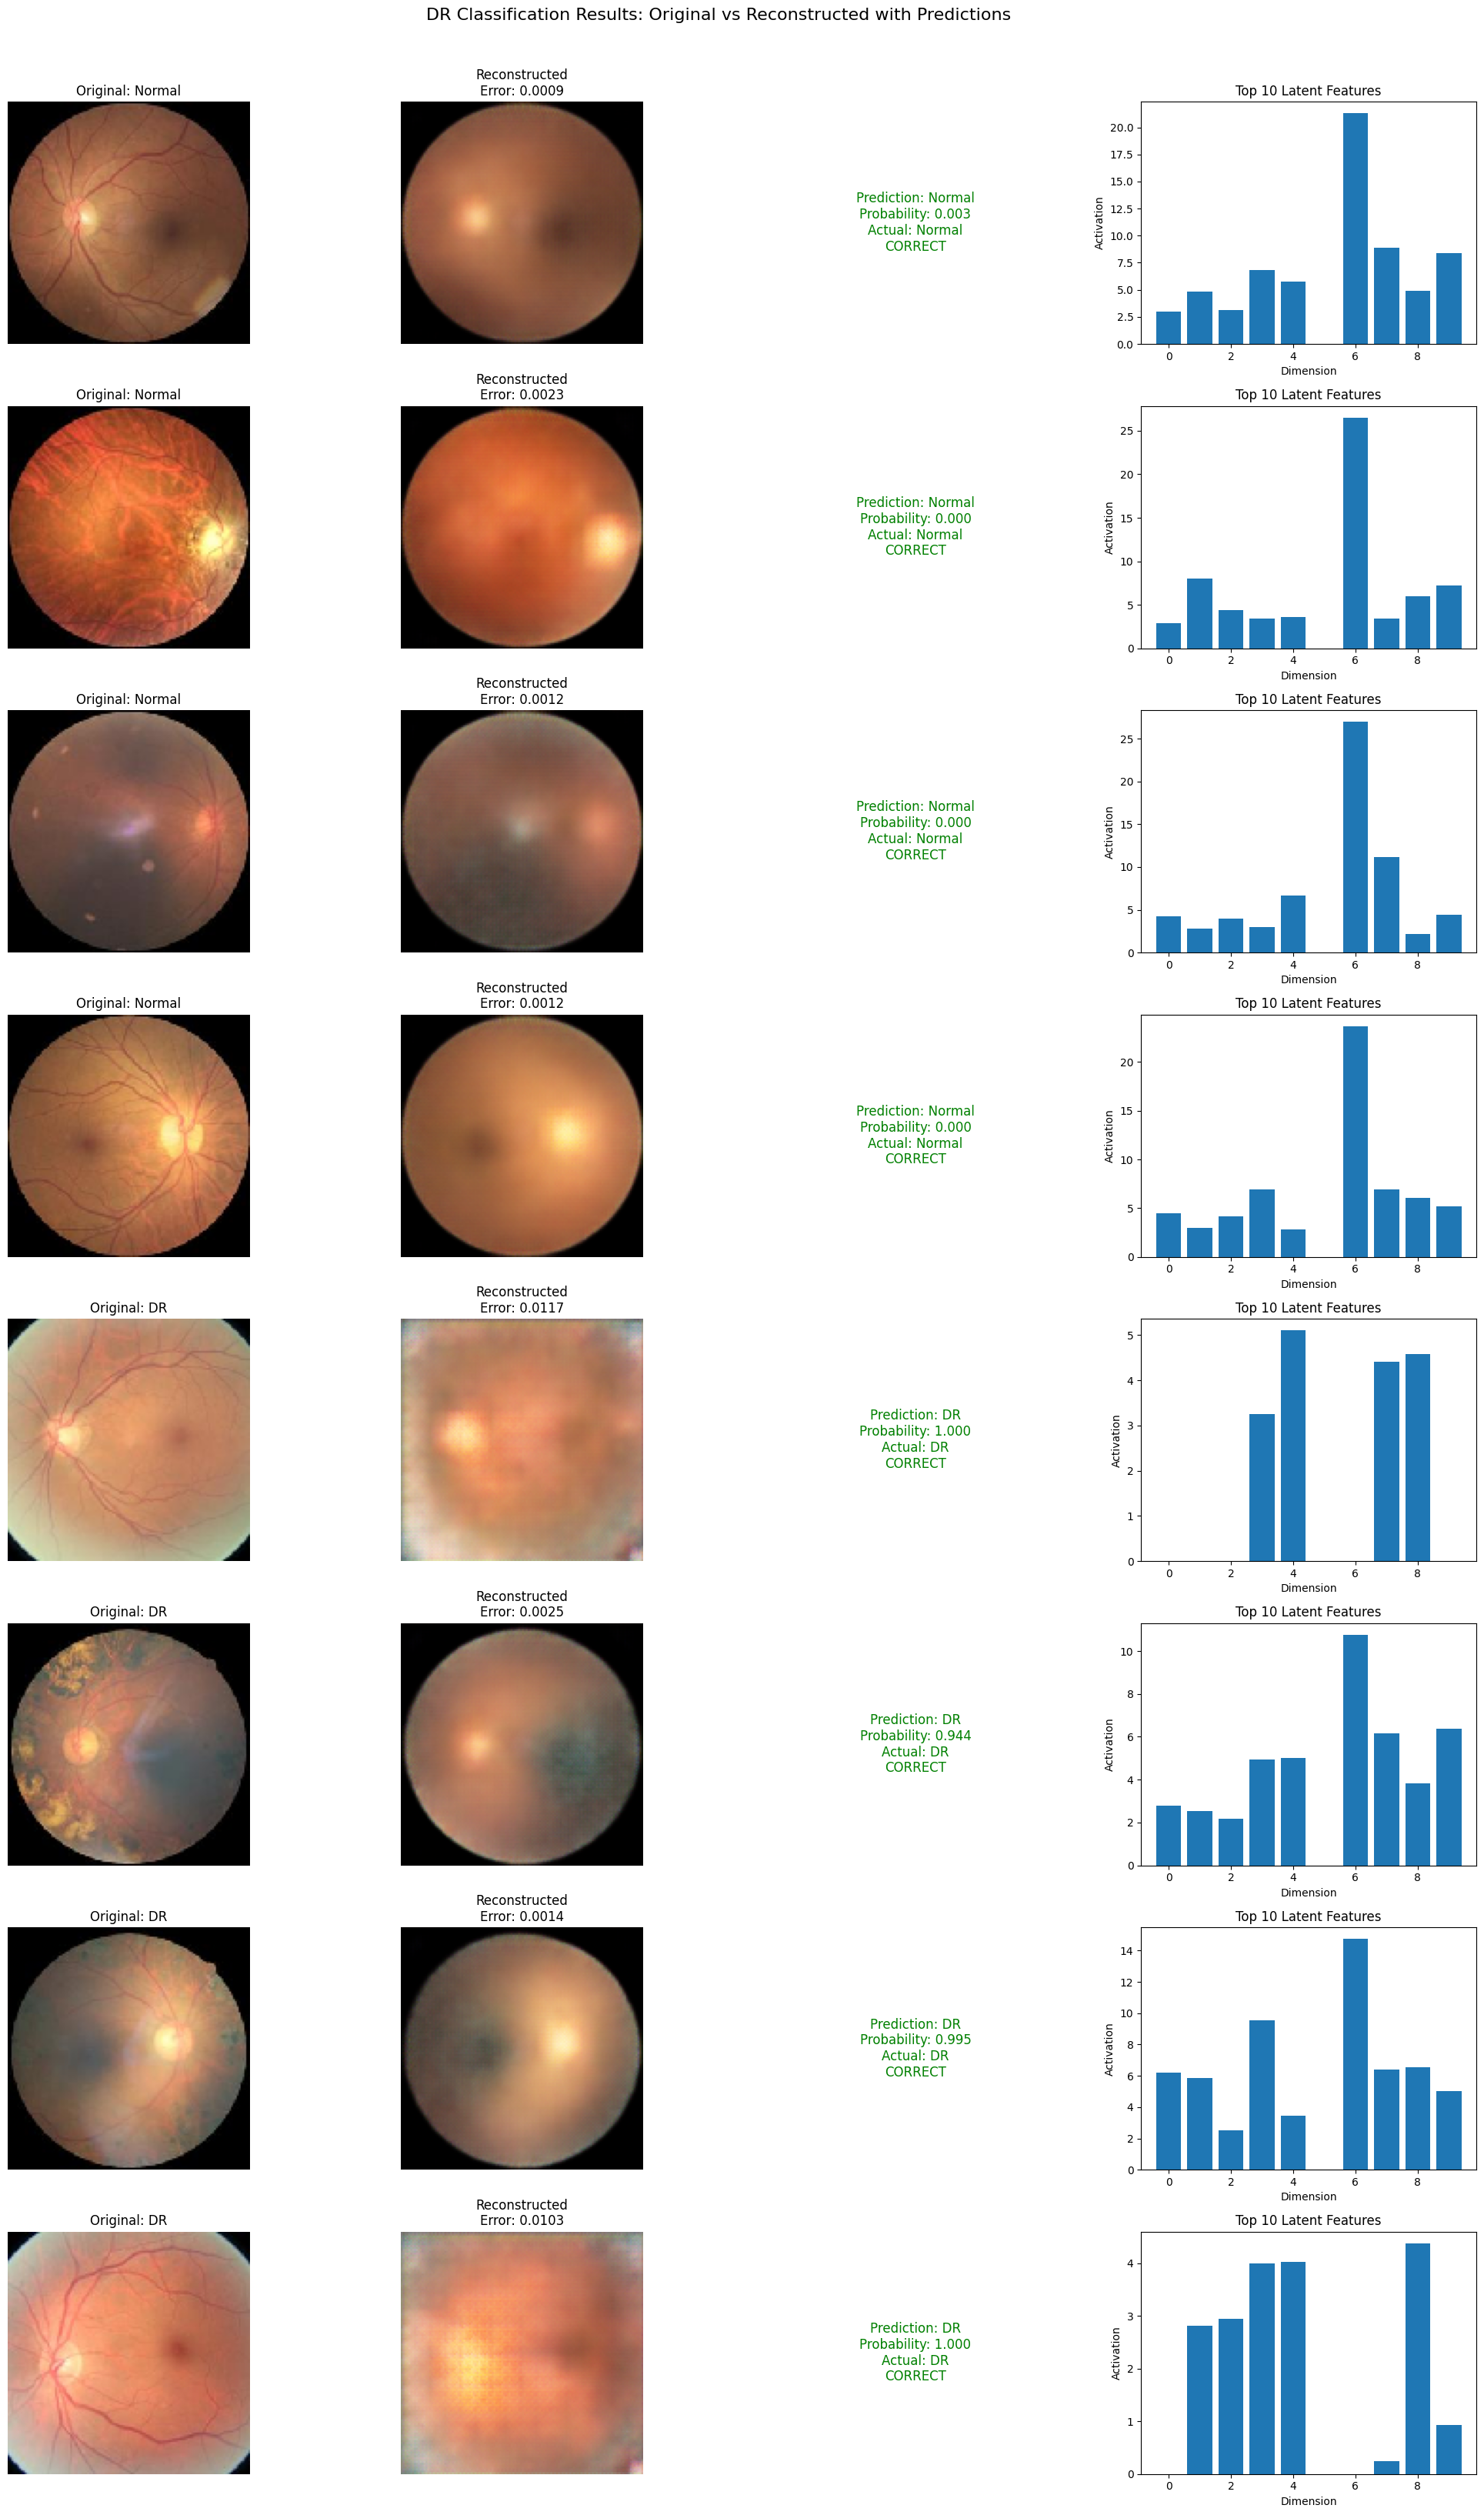


===== TEST SET PREDICTION METRICS =====
Test accuracy: 1.000
Class distribution in test set: {'Normal': np.int64(4), 'DR': np.int64(4)}
Sensitivity (DR Detection Rate): 1.000
Specificity (Normal Detection Rate): 1.000


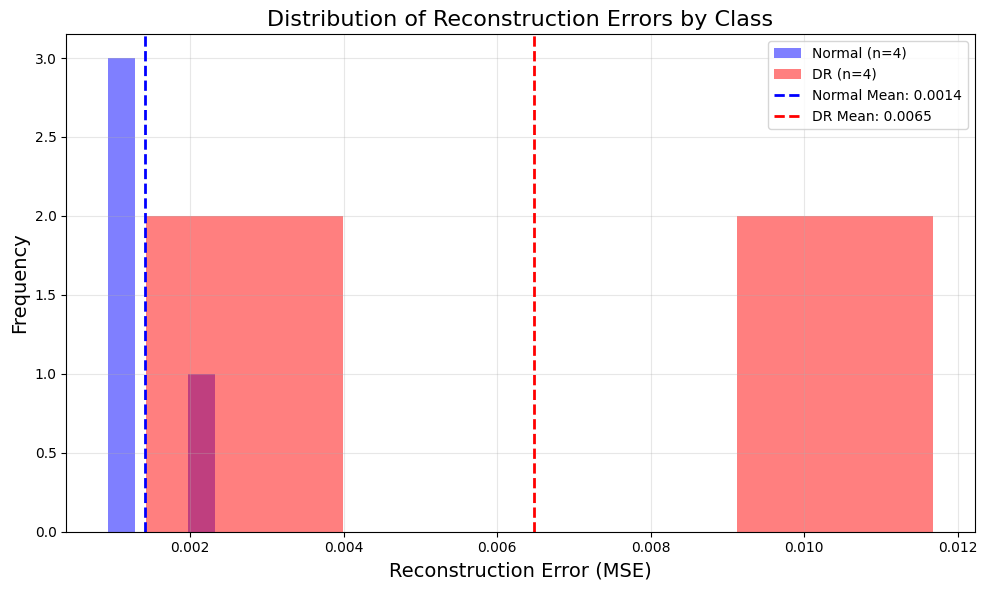

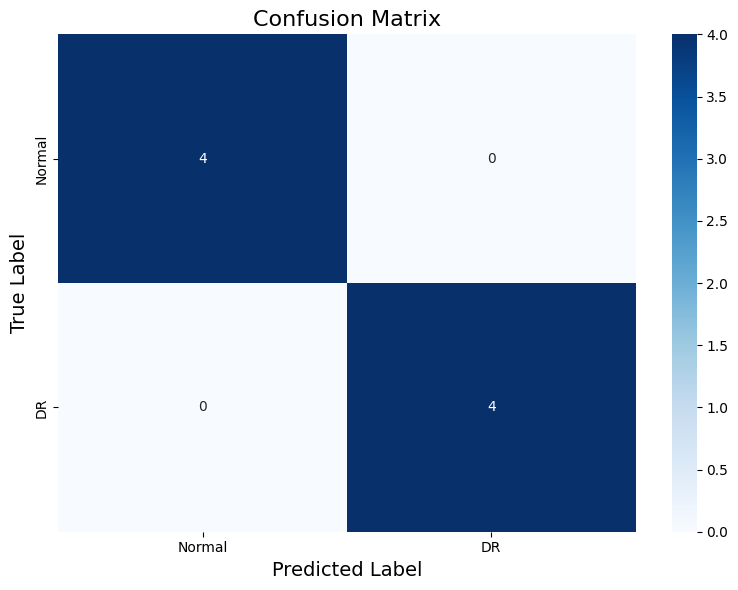

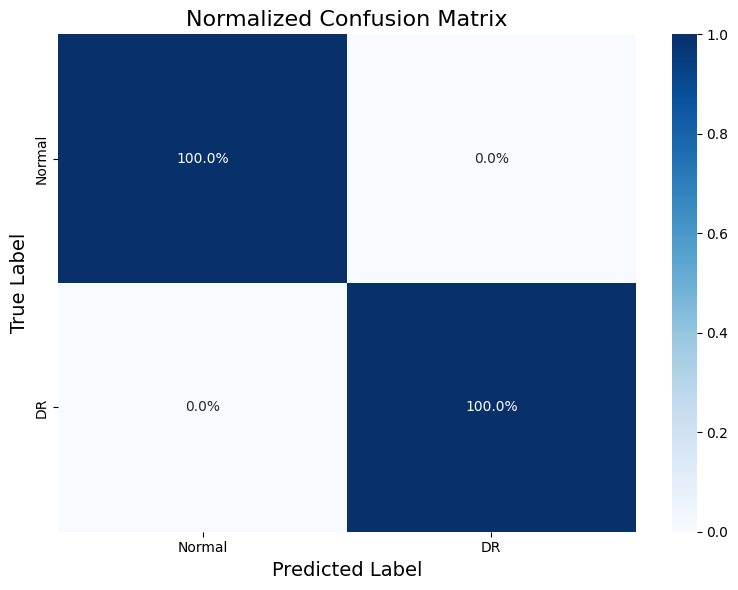

Error in t-SNE visualization: perplexity must be less than n_samples


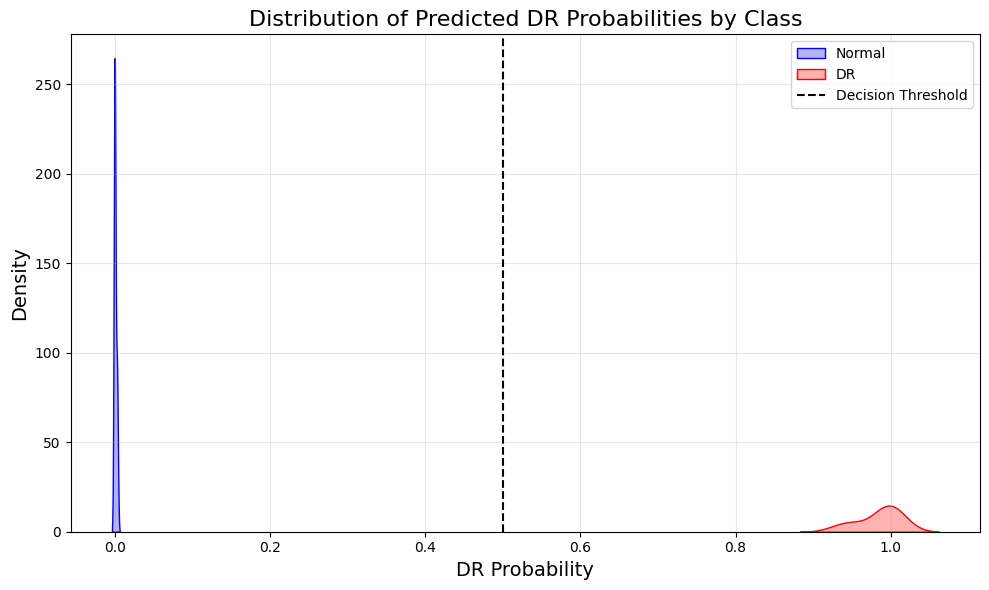


===== PERFORMANCE SUMMARY =====
Overall accuracy: 1.000
Sensitivity (DR detection rate): 1.000
Specificity (Normal detection rate): 1.000
Average reconstruction error:
  - Normal images: 0.0014
  - DR images: 0.0065


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
import matplotlib.gridspec as gridspec
from sklearn.calibration import calibration_curve

test_datagen = ImageDataGenerator(rescale=1./255)
test_labeled = test_datagen.flow_from_directory(
    'dr_dataset/testing/',  # Assuming your test data is in this directory
    target_size=IMG_SIZE,
    classes=['normal', 'dr'],
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)


# ======================
# Function to get balanced samples from testing dataset
# ======================
def get_balanced_samples(test_data_generator, n_samples_per_class=4):
    """
    Get a balanced set of normal and DR samples from the test dataset

    Parameters:
    - test_data_generator: Test data generator that yields (images, labels)
    - n_samples_per_class: Number of samples to get for each class

    Returns:
    - X_balanced: Array of balanced image samples
    - y_balanced: Array of corresponding labels
    """
    # Initialize arrays to store samples
    normal_samples = []
    normal_labels = []
    dr_samples = []
    dr_labels = []

    # Keep track of how many samples we've found
    normal_count = 0
    dr_count = 0

    # Set a limit to avoid infinite loop
    max_batches = 20
    batch_count = 0

    print("Finding balanced samples from test dataset...")

    # Loop through batches until we have enough samples or reach the max
    while (normal_count < n_samples_per_class or dr_count < n_samples_per_class) and batch_count < max_batches:
        try:
            # Get next batch
            X_batch, y_batch = next(test_data_generator)
            batch_count += 1

            # Find indices for each class
            normal_indices = np.where(y_batch.flatten() == 0)[0]
            dr_indices = np.where(y_batch.flatten() == 1)[0]

            # Add normal samples if needed
            if normal_count < n_samples_per_class and len(normal_indices) > 0:
                # Calculate how many more we need
                n_needed = min(n_samples_per_class - normal_count, len(normal_indices))
                # Add samples
                normal_samples.append(X_batch[normal_indices[:n_needed]])
                normal_labels.append(y_batch[normal_indices[:n_needed]])
                normal_count += n_needed

            # Add DR samples if needed
            if dr_count < n_samples_per_class and len(dr_indices) > 0:
                # Calculate how many more we need
                n_needed = min(n_samples_per_class - dr_count, len(dr_indices))
                # Add samples
                dr_samples.append(X_batch[dr_indices[:n_needed]])
                dr_labels.append(y_batch[dr_indices[:n_needed]])
                dr_count += n_needed

            print(f"Batch {batch_count}: Found {normal_count}/{n_samples_per_class} normal and {dr_count}/{n_samples_per_class} DR samples")

        except StopIteration:
            print("Reached end of dataset before finding enough samples")
            break

    # Check if we have any samples
    if not normal_samples and not dr_samples:
        raise ValueError("Could not find any samples in the dataset")

    # Combine the samples
    X_normal = np.vstack(normal_samples) if normal_samples else np.array([])
    y_normal = np.vstack(normal_labels) if normal_labels else np.array([])
    X_dr = np.vstack(dr_samples) if dr_samples else np.array([])
    y_dr = np.vstack(dr_labels) if dr_labels else np.array([])

    # Combine and shuffle (but keep track of indices for later)
    X_combined = np.vstack([X_normal, X_dr]) if len(X_normal) > 0 and len(X_dr) > 0 else (X_normal if len(X_normal) > 0 else X_dr)
    y_combined = np.vstack([y_normal, y_dr]) if len(y_normal) > 0 and len(y_dr) > 0 else (y_normal if len(y_normal) > 0 else y_dr)

    # Check final sample counts
    final_normal_count = np.sum(y_combined == 0)
    final_dr_count = np.sum(y_combined == 1)
    print(f"Final samples: {final_normal_count} normal and {final_dr_count} DR images")

    return X_combined, y_combined

# ======================
# Function to visualize model outputs and predictions
# ======================
def visualize_dr_model_results(autoencoder, encoder, classifier, X_test, y_test):
    """
    Generate comprehensive visualizations of DR model results

    Parameters:
    - autoencoder: The trained autoencoder model
    - encoder: The encoder part of the autoencoder
    - classifier: The DR classification model
    - X_test: Test images
    - y_test: Test labels

    Returns:
    - Dictionary with results metrics
    """
    # Make sure y_test is flattened
    y_test = y_test.flatten()

    # Get predictions
    reconstructed = autoencoder.predict(X_test, verbose=0)
    latent_features = encoder.predict(X_test, verbose=0)
    probabilities = classifier.predict(latent_features, verbose=0).flatten()
    predictions = (probabilities > 0.5).astype(int)

    # Calculate reconstruction errors
    if len(X_test.shape) > 2:  # Image data
        reconstruction_errors = np.mean(np.square(X_test - reconstructed), axis=tuple(range(1, len(X_test.shape))))
    else:  # Flattened data
        reconstruction_errors = np.mean(np.square(X_test - reconstructed), axis=1)

    # Number of samples
    num_samples = len(X_test)

    # 1. Visualize original vs reconstructed images
    plt.figure(figsize=(20, 4 * num_samples))
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 4, i*4 + 1)
        if len(X_test.shape) == 4:  # For image data with channels
            # Handle different channel formats
            if X_test.shape[-1] == 1:  # Grayscale
                plt.imshow(X_test[i].squeeze(), cmap='gray')
            elif X_test.shape[-1] == 3:  # RGB
                plt.imshow(X_test[i])
            else:  # Other formats
                plt.imshow(X_test[i, :, :, 0], cmap='gray')  # Show first channel
        else:  # For flattened data, try to reshape
            try:
                # Try standard image dimensions (assuming square)
                size = int(np.sqrt(X_test.shape[1]))
                plt.imshow(X_test[i].reshape(size, size), cmap='gray')
            except:
                plt.text(0.5, 0.5, "Cannot display\nflatted data",
                         ha='center', va='center', transform=plt.gca().transAxes)

        plt.title(f"Original: {'DR' if y_test[i] == 1 else 'Normal'}")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(num_samples, 4, i*4 + 2)
        if len(reconstructed.shape) == 4:  # For image data with channels
            # Handle different channel formats
            if reconstructed.shape[-1] == 1:  # Grayscale
                plt.imshow(reconstructed[i].squeeze(), cmap='gray')
            elif reconstructed.shape[-1] == 3:  # RGB
                plt.imshow(reconstructed[i])
            else:  # Other formats
                plt.imshow(reconstructed[i, :, :, 0], cmap='gray')  # Show first channel
        else:  # For flattened data, try to reshape
            try:
                # Try standard image dimensions (assuming square)
                size = int(np.sqrt(reconstructed.shape[1]))
                plt.imshow(reconstructed[i].reshape(size, size), cmap='gray')
            except:
                plt.text(0.5, 0.5, "Cannot display\nreconstructed data",
                         ha='center', va='center', transform=plt.gca().transAxes)

        plt.title(f"Reconstructed\nError: {reconstruction_errors[i]:.4f}")
        plt.axis('off')

        # Prediction info
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.axis('off')
        correct = predictions[i] == y_test[i]
        color = 'green' if correct else 'red'
        plt.text(0.5, 0.5,
                 f"Prediction: {'DR' if predictions[i] == 1 else 'Normal'}\n" +
                 f"Probability: {probabilities[i]:.3f}\n" +
                 f"Actual: {'DR' if y_test[i] == 1 else 'Normal'}\n" +
                 f"{'CORRECT' if correct else 'INCORRECT'}",
                 ha='center', va='center', fontsize=12, color=color,
                 transform=plt.gca().transAxes)

        # Latent features visualization
        plt.subplot(num_samples, 4, i*4 + 4)
        # Show top 10 latent dimensions
        num_dims = min(10, latent_features.shape[1])
        plt.bar(range(num_dims), latent_features[i][:num_dims])
        plt.title(f"Top {num_dims} Latent Features")
        plt.xlabel("Dimension")
        plt.ylabel("Activation")

    plt.tight_layout()
    plt.suptitle("DR Classification Results: Original vs Reconstructed with Predictions", fontsize=16, y=1.02)
    plt.show()

    # 2. Show overall metrics on the test set
    print("\n===== TEST SET PREDICTION METRICS =====")
    accuracy = np.mean(predictions == y_test)
    print(f"Test accuracy: {accuracy:.3f}")

    # Class distribution
    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = dict(zip(['Normal', 'DR'] if len(unique) > 1 else ['Normal' if 0 in unique else 'DR'], counts))
    print(f"Class distribution in test set: {class_dist}")

    # Calculate sensitivity and specificity if both classes present
    if len(unique) > 1:
        sensitivity = recall_score(y_test, predictions)
        specificity = recall_score(1 - y_test, 1 - predictions)
        print(f"Sensitivity (DR Detection Rate): {sensitivity:.3f}")
        print(f"Specificity (Normal Detection Rate): {specificity:.3f}")

    # 3. Plot reconstruction error distributions by class
    plt.figure(figsize=(10, 6))

    # Split errors by class
    errors_normal = reconstruction_errors[y_test == 0] if 0 in y_test else np.array([])
    errors_dr = reconstruction_errors[y_test == 1] if 1 in y_test else np.array([])

    # Plot histograms if we have examples of each class
    if len(errors_normal) > 0:
        plt.hist(errors_normal, bins=min(10, len(errors_normal)), alpha=0.5,
                 label=f'Normal (n={len(errors_normal)})', color='blue')

    if len(errors_dr) > 0:
        plt.hist(errors_dr, bins=min(10, len(errors_dr)), alpha=0.5,
                 label=f'DR (n={len(errors_dr)})', color='red')

    # Calculate mean errors for each class
    mean_normal = np.mean(errors_normal) if len(errors_normal) > 0 else 0
    mean_dr = np.mean(errors_dr) if len(errors_dr) > 0 else 0

    # Add mean lines
    if len(errors_normal) > 0:
        plt.axvline(mean_normal, color='blue', linestyle='dashed', linewidth=2,
                    label=f'Normal Mean: {mean_normal:.4f}')
    if len(errors_dr) > 0:
        plt.axvline(mean_dr, color='red', linestyle='dashed', linewidth=2,
                    label=f'DR Mean: {mean_dr:.4f}')

    plt.xlabel('Reconstruction Error (MSE)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Reconstruction Errors by Class', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Generate a confusion matrix for the test set
    try:
        if len(unique) > 1:
            cm = confusion_matrix(y_test, predictions)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Normal', 'DR'], yticklabels=['Normal', 'DR'])
            plt.xlabel('Predicted Label', fontsize=14)
            plt.ylabel('True Label', fontsize=14)
            plt.title('Confusion Matrix', fontsize=16)
            plt.tight_layout()
            plt.show()

            # Add normalized confusion matrix (percentages)
            cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='Blues',
                        xticklabels=['Normal', 'DR'], yticklabels=['Normal', 'DR'])
            plt.xlabel('Predicted Label', fontsize=14)
            plt.ylabel('True Label', fontsize=14)
            plt.title('Normalized Confusion Matrix', fontsize=16)
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Error generating confusion matrix: {str(e)}")

    # 5. Latent space visualization (t-SNE if available)
    try:
        from sklearn.manifold import TSNE

        # Only perform t-SNE if we have enough samples
        if len(latent_features) >= 5:
            # Apply t-SNE to latent features
            tsne = TSNE(n_components=2, random_state=42)
            latent_2d = tsne.fit_transform(latent_features)

            # Create scatter plot
            plt.figure(figsize=(10, 8))

            # Plot points for each class
            if 0 in y_test:
                plt.scatter(latent_2d[y_test == 0, 0], latent_2d[y_test == 0, 1],
                           c='blue', label='Normal', alpha=0.7)

            if 1 in y_test:
                plt.scatter(latent_2d[y_test == 1, 0], latent_2d[y_test == 1, 1],
                           c='red', label='DR', alpha=0.7)

            plt.xlabel('t-SNE Dimension 1', fontsize=14)
            plt.ylabel('t-SNE Dimension 2', fontsize=14)
            plt.title('t-SNE Visualization of Latent Space', fontsize=16)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    except ImportError:
        print("t-SNE not available for latent space visualization")
    except Exception as e:
        print(f"Error in t-SNE visualization: {str(e)}")

    # 6. Plot probability distribution
    plt.figure(figsize=(10, 6))

    # Split by true class
    probs_normal = probabilities[y_test == 0] if 0 in y_test else np.array([])
    probs_dr = probabilities[y_test == 1] if 1 in y_test else np.array([])

    # Plot density estimates
    if len(probs_normal) > 2:
        sns.kdeplot(probs_normal, label='Normal', color='blue', fill=True, alpha=0.3)
    if len(probs_dr) > 2:
        sns.kdeplot(probs_dr, label='DR', color='red', fill=True, alpha=0.3)

    # Add decision threshold line
    plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold')

    plt.xlabel('DR Probability', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title('Distribution of Predicted DR Probabilities by Class', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predictions': predictions,
        'probabilities': probabilities,
        'reconstruction_errors': reconstruction_errors,
        'sensitivity': sensitivity if len(unique) > 1 else None,
        'specificity': specificity if len(unique) > 1 else None
    }

# ======================
# Code to run the balanced visualization
# ======================

# To use this code, run the following:
print("=" * 50)
print("DR MODEL OUTPUT VISUALIZATION WITH BALANCED SAMPLES")
print("=" * 50)

# Get balanced samples from test dataset
X_balanced, y_balanced = get_balanced_samples(test_labeled, n_samples_per_class=4)

# Run visualization on balanced samples
results = visualize_dr_model_results(autoencoder, encoder, classifier, X_balanced, y_balanced)

# Additional summary metrics
print("\n===== PERFORMANCE SUMMARY =====")
print(f"Overall accuracy: {results['accuracy']:.3f}")
if results['sensitivity'] is not None:
    print(f"Sensitivity (DR detection rate): {results['sensitivity']:.3f}")
    print(f"Specificity (Normal detection rate): {results['specificity']:.3f}")
print(f"Average reconstruction error:")
print(f"  - Normal images: {np.mean(results['reconstruction_errors'][y_balanced.flatten() == 0]):.4f}")
print(f"  - DR images: {np.mean(results['reconstruction_errors'][y_balanced.flatten() == 1]):.4f}")